In [1]:
%matplotlib inline

In [2]:
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

In [3]:
def load_directory(path):
    onlyfiles = ["%s/%s" %(path, f) for f in listdir(path) if isfile(join(path, f))]
    dfs = []
    
    for f in onlyfiles:
        dfs.append(pd.read_csv(f, sep='\t'))
    return pd.concat(dfs)

In [4]:
def plot_experiment(xp_path):
    df = load_directory(xp_path)
    gpdf = df.groupby(["sim_step", "xp_name"]).agg(np.mean).reset_index().set_index("sim_step")
    max_index = int(math.ceil(gpdf[["eps_min_diff", "eps_min_sstab"]].max().max()) + 2)
    max_index_diff = int(math.ceil(gpdf[["eps_min_diff"]].max().max()))
    max_index_sstab = int(math.ceil(gpdf[["eps_min_sstab"]].max().max()))    
    
    ltx_table = pd.concat([gpdf[gpdf.index==max_index_diff*50], gpdf[gpdf.index==max_index_sstab*50]])
    
    with open("msthesis/csv/%s.tex" %xp_path, "w+") as fp:
        ltx_table = ltx_table[["nmsg_diff", "delta_diff", "energy_diff", "nmsg_sstab", "delta_sstab", "energy_sstab"]]
        new_cols = []
        ltx_table["Time"] = ltx_table.index
        ltx_table["Algorithm"] = ["Diffusion", "Self-stab"]
        ltx_table["Degree"] = gpdf["degree_sstab"]
        ltx_table = ltx_table[list(ltx_table.columns)[-3:] + list(ltx_table.columns)[:-3]]
        for col in ltx_table.columns:
            if col.endswith("_sstab"):
                new_cols.append(("Self-stab", col.split("_")[0]))
            elif col.endswith("_diff"):
                new_cols.append(("Diffusion", col.split("_")[0]))
            else:
                new_cols.append(("\multicolumn{3}{c}{}", col))
        print new_cols
        ltx_table.columns = pd.MultiIndex.from_tuples(new_cols)
        desc = xp_path.replace("-", " and ").replace("_", " ")
        label = xp_path.replace("-", "").replace("_", "")
        fp.write("\\begin{figure}\caption{Convergence iterations for experiment $description \label{tab:$label}}".replace("$xp_path", xp_path).\
                 replace("$description", desc).replace("$label", label))
        fp.write(ltx_table.to_latex(index=False, bold_rows=True, escape=False, 
                                    multirow=True, float_format="%.3lf", 
                                    column_format="r|l|r|r|r|r|r|r|r",
                                    multicolumn_format="|c"))        
        fp.write("\end{figure}")
        fp.write("""
\\begin{figure}
  \caption{Experiment with $description \label{fig:$label}}
  \\begin{subfigure}[b]{0.5\\textwidth}
    \includegraphics[width=\\textwidth]{images/$xp_path_delta.png}
    \caption{Maximum delta convergence \label{fig:$label_delta}}  
  \end{subfigure}
  %
  \\begin{subfigure}[b]{0.5\\textwidth}
    \includegraphics[width=\\textwidth]{images/$xp_path_nmsg.png}
    \caption{Number of exchanged messages    \label{fig:$label_nmsg}}
  \end{subfigure}
  
  \\begin{subfigure}[b]{0.5\\textwidth}
    \includegraphics[width=\\textwidth]{images/$xp_path_energy.png}
    \caption{Energy consumption \label{fig:$label_energy}}
  \end{subfigure}
\end{figure}
        """.replace("$xp_path", xp_path).replace("$description", desc).replace("$label", label))
        print ltx_table
    
    pgdf_sub = gpdf[gpdf.index <= max_index * 50]
    pgdf_sub.index = pgdf_sub.index.rename("Simulation time (ms)")
    plt.style.use('ggplot')
    pgdf_sub[["nmsg_sstab", "nmsg_diff"]].rename(columns={"nmsg_sstab": "Self-stab - Messages exchanged",
                                              "nmsg_diff": "Diffusion - Messages exchanged"}).plot(grid=True)
    plt.axvline(x=max_index_diff * 50, color='b', linestyle='--', label="Diffusion convergence state")
    plt.axvline(x=max_index_sstab * 50, color='r', linestyle='--', label="Self-stab convergence state")
    plt.legend(loc=0)
    plt.savefig('msthesis/images/%s_nmsg.png' %xp_path)

    pgdf_sub[["delta_sstab", "delta_diff"]].rename(columns={"delta_sstab": "Self-stab - Maximum delta",
                                              "delta_diff": "Diffusion - Maximum delta"}).plot(grid=True)
    plt.axvline(x=max_index_diff * 50, color='b', linestyle='--', label="Diffusion convergence state")
    plt.axvline(x=max_index_sstab * 50, color='r', linestyle='--', label="Self-stab convergence state")
    plt.legend(loc=0)
    plt.savefig('msthesis/images/%s_delta.png' %xp_path)

    pgdf_sub[["energy_sstab", "energy_diff"]].rename(columns={"energy_sstab": "Self-stab - Energy",
                                              "energy_diff": "Diffusion - Energy"}).plot(grid=True)
    plt.axvline(x=max_index_diff * 50, color='b', linestyle='--', label="Diffusion convergence state")
    plt.axvline(x=max_index_sstab * 50, color='r', linestyle='--', label="Self-stab convergence state")
    plt.legend(loc=0)
    plt.savefig('msthesis/images/%s_energy.png' %xp_path)
    
    return ltx_table
    

In [5]:
def get_metrics_line(dist, df):
    deg = df["\multicolumn{3}{c}{}"]["Degree"].values[0]
    diff = df[df["\multicolumn{3}{c}{}"]["Algorithm"]=="Diffusion"]["Diffusion"].reset_index()
    sstab = df[df["\multicolumn{3}{c}{}"]["Algorithm"]=="Self-stab"]["Self-stab"].reset_index()

    vals = diff.values.ravel().tolist() + sstab.values.ravel().tolist()
    df = pd.DataFrame(index=[dist], data=[vals], columns=map(lambda x: "Diffusion_" + x, diff.columns.tolist()) 
             + map(lambda x: "Self-stab_" + x, sstab.columns.tolist()))
    df["Degree"] = deg
    return df

## 10 nodes with 20 distance

In [151]:
xplist = []

[('\\multicolumn{3}{c}{}', 'Time'), ('\\multicolumn{3}{c}{}', 'Algorithm'), ('\\multicolumn{3}{c}{}', 'Degree'), ('Diffusion', 'nmsg'), ('Diffusion', 'delta'), ('Diffusion', 'energy'), ('Self-stab', 'nmsg'), ('Self-stab', 'delta'), ('Self-stab', 'energy')]
         \multicolumn{3}{c}{}                   Diffusion                  \
                         Time  Algorithm Degree      nmsg    delta energy   
sim_step                                                                    
900                       900  Diffusion  1.812    1359.0  0.01067  0.918   
1450                     1450  Self-stab  1.812    2174.4  0.00144  0.868   

         Self-stab                     
              nmsg    delta    energy  
sim_step                               
900         466.43  0.08408  0.933391  
1450        860.80  0.01002  0.888493  


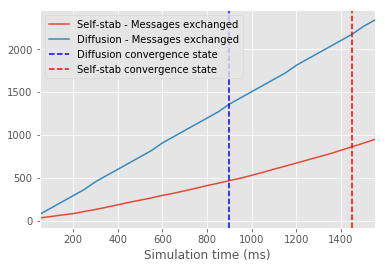

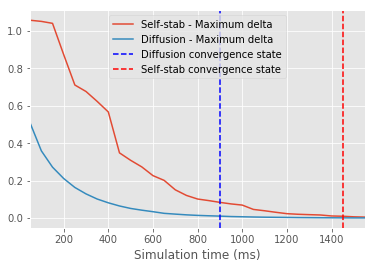

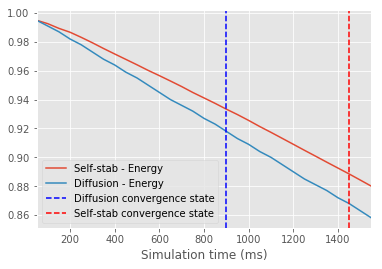

In [152]:
xplist.append(get_metrics_line(10, plot_experiment("nnodes_10-distance_10")))

[('\\multicolumn{3}{c}{}', 'Time'), ('\\multicolumn{3}{c}{}', 'Algorithm'), ('\\multicolumn{3}{c}{}', 'Degree'), ('Diffusion', 'nmsg'), ('Diffusion', 'delta'), ('Diffusion', 'energy'), ('Self-stab', 'nmsg'), ('Self-stab', 'delta'), ('Self-stab', 'energy')]
         \multicolumn{3}{c}{}                   Diffusion                  \
                         Time  Algorithm Degree      nmsg    delta energy   
sim_step                                                                    
1250                     1250  Diffusion  1.928   2005.12  0.01013  0.885   
1550                     1550  Self-stab  1.928   2487.12  0.00471  0.858   

         Self-stab                     
              nmsg    delta    energy  
sim_step                               
1250        897.10  0.02754  0.903888  
1550       1183.68  0.01244  0.879391  


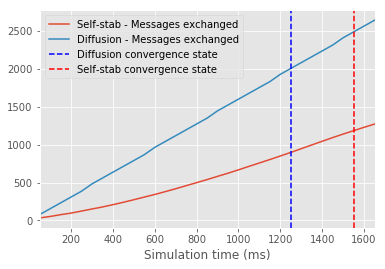

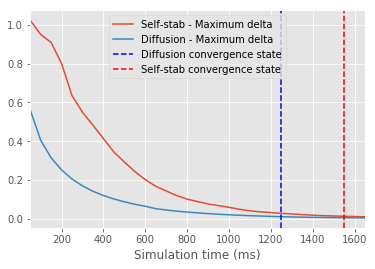

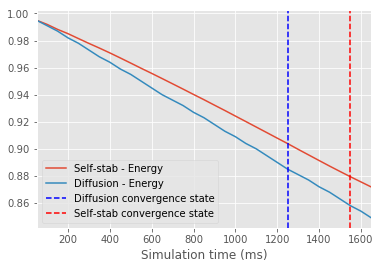

In [153]:
xplist.append(get_metrics_line(20, plot_experiment("nnodes_10-distance_20")))

[('\\multicolumn{3}{c}{}', 'Time'), ('\\multicolumn{3}{c}{}', 'Algorithm'), ('\\multicolumn{3}{c}{}', 'Degree'), ('Diffusion', 'nmsg'), ('Diffusion', 'delta'), ('Diffusion', 'energy'), ('Self-stab', 'nmsg'), ('Self-stab', 'delta'), ('Self-stab', 'energy')]
         \multicolumn{3}{c}{}                   Diffusion                  \
                         Time  Algorithm Degree      nmsg    delta energy   
sim_step                                                                    
1450                     1450  Diffusion   2.36    2832.0  0.00993  0.868   
2000                     2000  Self-stab   2.36    3917.6  0.00312  0.817   

         Self-stab                     
              nmsg    delta    energy  
sim_step                               
1450       1439.55  0.04277  0.885387  
2000       1998.74  0.01758  0.845563  


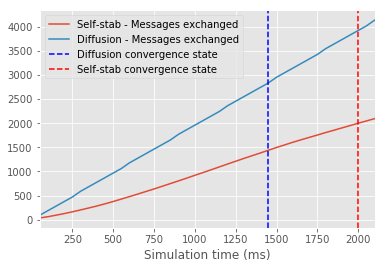

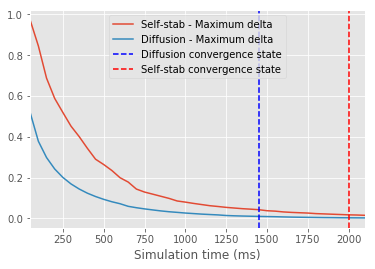

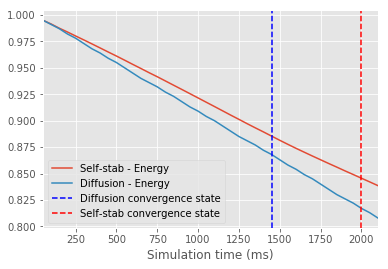

In [154]:
xplist.append(get_metrics_line(30, plot_experiment("nnodes_10-distance_30")))

[('\\multicolumn{3}{c}{}', 'Time'), ('\\multicolumn{3}{c}{}', 'Algorithm'), ('\\multicolumn{3}{c}{}', 'Degree'), ('Diffusion', 'nmsg'), ('Diffusion', 'delta'), ('Diffusion', 'energy'), ('Self-stab', 'nmsg'), ('Self-stab', 'delta'), ('Self-stab', 'energy')]
         \multicolumn{3}{c}{}                   Diffusion                  \
                         Time  Algorithm Degree      nmsg    delta energy   
sim_step                                                                    
1150                     1150  Diffusion  3.278   3114.10  0.01305  0.895   
2450                     2450  Self-stab  3.278   6687.12  0.00067  0.775   

         Self-stab                     
              nmsg    delta    energy  
sim_step                               
1150       1319.68  0.14931  0.909223  
2450       2937.74  0.02924  0.811889  


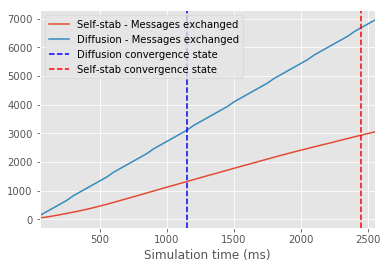

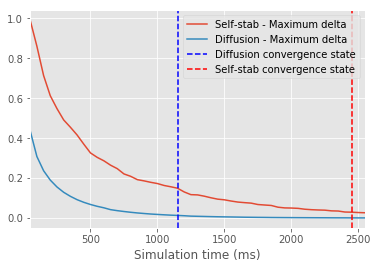

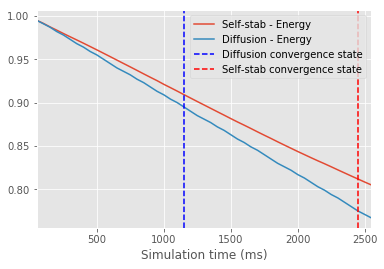

In [155]:
xplist.append(get_metrics_line(40, plot_experiment("nnodes_10-distance_40")))

[('\\multicolumn{3}{c}{}', 'Time'), ('\\multicolumn{3}{c}{}', 'Algorithm'), ('\\multicolumn{3}{c}{}', 'Degree'), ('Diffusion', 'nmsg'), ('Diffusion', 'delta'), ('Diffusion', 'energy'), ('Self-stab', 'nmsg'), ('Self-stab', 'delta'), ('Self-stab', 'energy')]
         \multicolumn{3}{c}{}                   Diffusion                  \
                         Time  Algorithm Degree      nmsg    delta energy   
sim_step                                                                    
700                       700  Diffusion  4.378   2539.24  0.01516  0.936   
2250                     2250  Self-stab  4.378   8186.86  0.00024  0.794   

         Self-stab                     
              nmsg    delta    energy  
sim_step                               
700         847.34  0.27526  0.943941  
2250       3167.65  0.02908  0.823601  


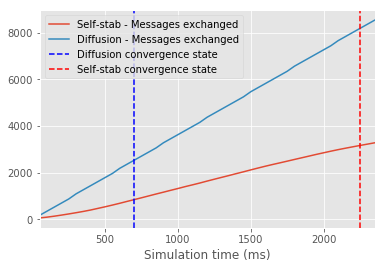

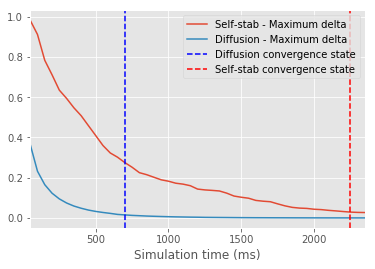

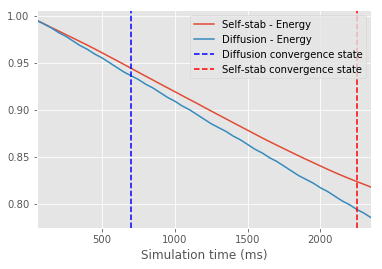

In [156]:
xplist.append(get_metrics_line(50, plot_experiment("nnodes_10-distance_50")))

In [157]:
synth = pd.concat(xplist).set_index("Degree")

In [158]:
synth

,Diffusion_sim_step,Diffusion_nmsg,Diffusion_delta,Diffusion_energy,Self-stab_sim_step,Self-stab_nmsg,Self-stab_delta,Self-stab_energy
Degree,,,,,,,,
1.812,900.0,1359.00,0.01067,0.918,1450.0,860.80,0.01002,0.888493
1.928,1250.0,2005.12,0.01013,0.885,1550.0,1183.68,0.01244,0.879391
2.360,1450.0,2832.00,0.00993,0.868,2000.0,1998.74,0.01758,0.845563
3.278,1150.0,3114.10,0.01305,0.895,2450.0,2937.74,0.02924,0.811889
4.378,700.0,2539.24,0.01516,0.936,2250.0,3167.65,0.02908,0.823601


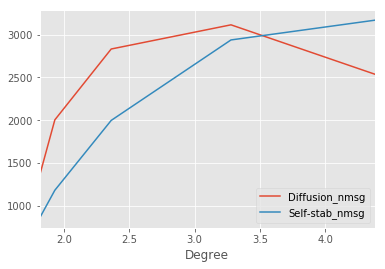

In [159]:
synth[["Diffusion_nmsg", "Self-stab_nmsg"]].plot()
plt.savefig('msthesis/images/cmp_nmsg.png')

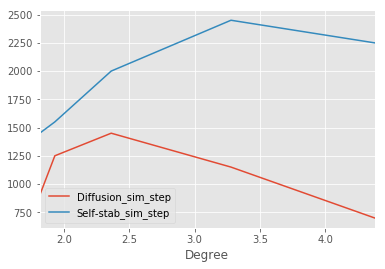

In [160]:
synth[["Diffusion_sim_step", "Self-stab_sim_step"]].plot()
plt.savefig('msthesis/images/cmp_sim_step.png')

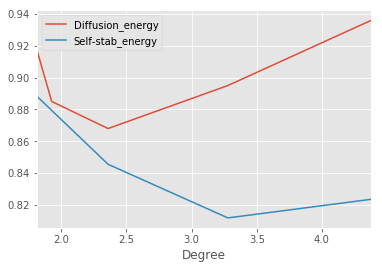

In [161]:
synth[["Diffusion_energy", "Self-stab_energy"]].plot()
plt.savefig('msthesis/images/cmp_energy.png')

## Scaling

In [6]:
xplist = []

[('\\multicolumn{3}{c}{}', 'Time'), ('\\multicolumn{3}{c}{}', 'Algorithm'), ('\\multicolumn{3}{c}{}', 'Degree'), ('Diffusion', 'nmsg'), ('Diffusion', 'delta'), ('Diffusion', 'energy'), ('Self-stab', 'nmsg'), ('Self-stab', 'delta'), ('Self-stab', 'energy')]
         \multicolumn{3}{c}{}                   Diffusion                  \
                         Time  Algorithm Degree      nmsg    delta energy   
sim_step                                                                    
900                       900  Diffusion  1.812    1359.0  0.01067  0.918   
1450                     1450  Self-stab  1.812    2174.4  0.00144  0.868   

         Self-stab                     
              nmsg    delta    energy  
sim_step                               
900         466.43  0.08408  0.933391  
1450        860.80  0.01002  0.888493  


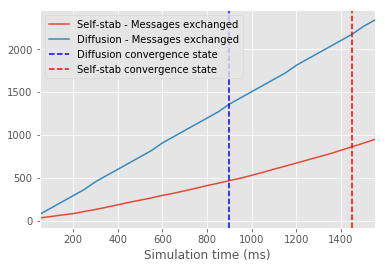

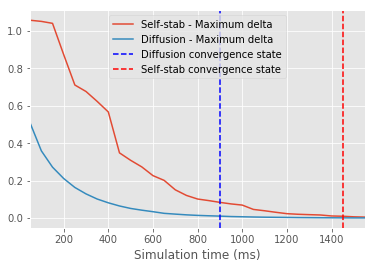

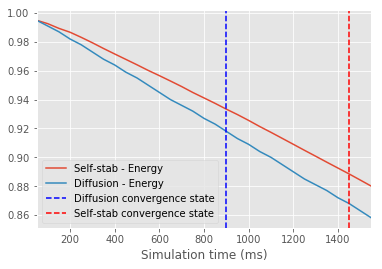

In [7]:
xplist.append(get_metrics_line(10, plot_experiment("nnodes_10-distance_10")))

[('\\multicolumn{3}{c}{}', 'Time'), ('\\multicolumn{3}{c}{}', 'Algorithm'), ('\\multicolumn{3}{c}{}', 'Degree'), ('Diffusion', 'nmsg'), ('Diffusion', 'delta'), ('Diffusion', 'energy'), ('Self-stab', 'nmsg'), ('Self-stab', 'delta'), ('Self-stab', 'energy')]
         \multicolumn{3}{c}{}                         Diffusion            \
                         Time  Algorithm   Degree          nmsg     delta   
sim_step                                                                    
2600                     2600  Diffusion  1.95914   8463.483871  0.012785   
3550                     3550  Self-stab  1.95914  11558.924731  0.004333   

                   Self-stab                      
         energy         nmsg     delta    energy  
sim_step                                          
2600      0.762  3344.010753  0.037118  0.813112  
3550      0.675  4871.236559  0.010634  0.740130  


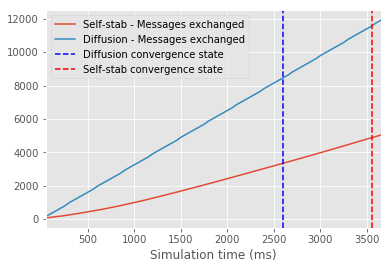

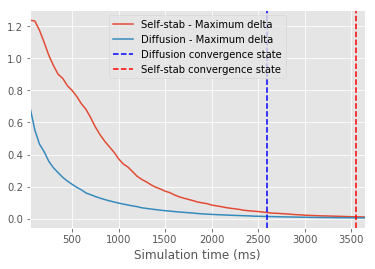

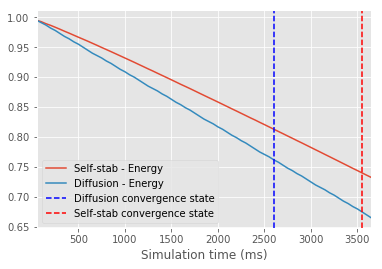

In [8]:
xplist.append(get_metrics_line(20, plot_experiment("nnodes_20-distance_10")))

[('\\multicolumn{3}{c}{}', 'Time'), ('\\multicolumn{3}{c}{}', 'Algorithm'), ('\\multicolumn{3}{c}{}', 'Degree'), ('Diffusion', 'nmsg'), ('Diffusion', 'delta'), ('Diffusion', 'energy'), ('Self-stab', 'nmsg'), ('Self-stab', 'delta'), ('Self-stab', 'energy')]
         \multicolumn{3}{c}{}                          Diffusion            \
                         Time  Algorithm    Degree          nmsg     delta   
sim_step                                                                     
6550                     6550  Diffusion  2.154891  46976.630435  0.012457   
9050                     9050  Self-stab  2.154891  64991.521739  0.004924   

                    Self-stab                      
         energy          nmsg     delta    energy  
sim_step                                           
6550       0.40  16678.315217  0.041685  0.592216  
9050       0.17  23419.293478  0.017652  0.431640  


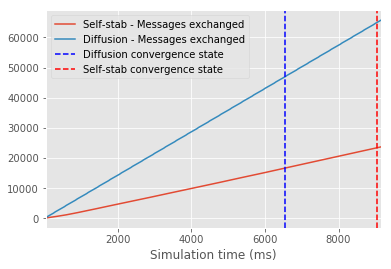

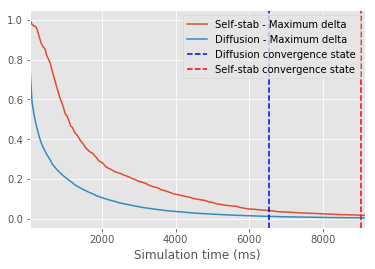

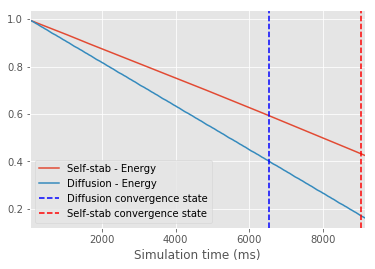

In [9]:
xplist.append(get_metrics_line(40, plot_experiment("nnodes_40-distance_10")))

[('\\multicolumn{3}{c}{}', 'Time'), ('\\multicolumn{3}{c}{}', 'Algorithm'), ('\\multicolumn{3}{c}{}', 'Degree'), ('Diffusion', 'nmsg'), ('Diffusion', 'delta'), ('Diffusion', 'energy'), ('Self-stab', 'nmsg'), ('Self-stab', 'delta'), ('Self-stab', 'energy')]
         \multicolumn{3}{c}{}                           Diffusion            \
                         Time  Algorithm    Degree           nmsg     delta   
sim_step                                                                      
10750                   10750  Diffusion  2.439927  131024.065934  0.013154   
16600                   16600  Self-stab  2.439927  202465.120879  0.003824   

                     Self-stab                      
          energy          nmsg     delta    energy  
sim_step                                            
10750     0.0152  36617.560440  0.122813  0.442566  
16600     0.0000  55945.241758  0.063769  0.284100  


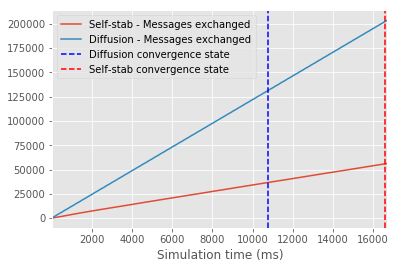

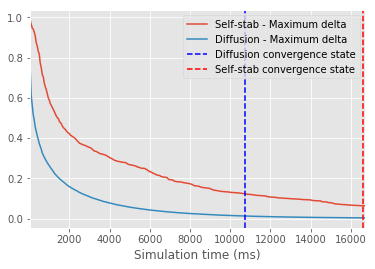

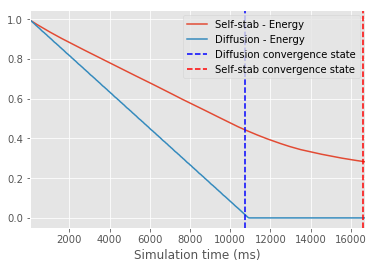

In [10]:
xplist.append(get_metrics_line(60, plot_experiment("nnodes_60-distance_10")))

In [11]:
xplist[0]

,Diffusion_sim_step,Diffusion_nmsg,Diffusion_delta,Diffusion_energy,Self-stab_sim_step,Self-stab_nmsg,Self-stab_delta,Self-stab_energy,Degree
10,900.0,1359.0,0.01067,0.918,1450.0,860.8,0.01002,0.888493,1.812


In [12]:
synth = pd.concat(xplist)

In [13]:
synth

,Diffusion_sim_step,Diffusion_nmsg,Diffusion_delta,Diffusion_energy,Self-stab_sim_step,Self-stab_nmsg,Self-stab_delta,Self-stab_energy,Degree
10,900.0,1359.000000,0.010670,0.9180,1450.0,860.800000,0.010020,0.888493,1.812000
20,2600.0,8463.483871,0.012785,0.7620,3550.0,4871.236559,0.010634,0.740130,1.959140
40,6550.0,46976.630435,0.012457,0.4000,9050.0,23419.293478,0.017652,0.431640,2.154891
60,10750.0,131024.065934,0.013154,0.0152,16600.0,55945.241758,0.063769,0.284100,2.439927


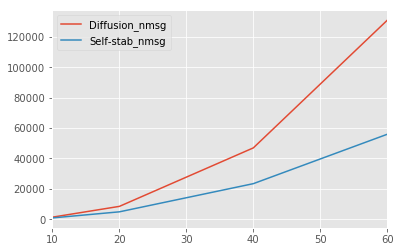

In [14]:
synth[["Diffusion_nmsg", "Self-stab_nmsg"]].plot()
plt.savefig('msthesis/images/scale_nmsg.png')

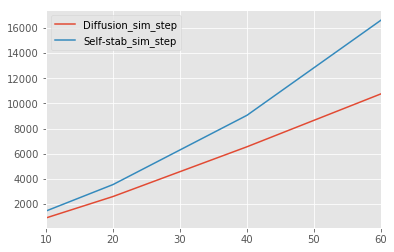

In [15]:
synth[["Diffusion_sim_step", "Self-stab_sim_step"]].plot()
plt.savefig('msthesis/images/scale_sim_step.png')

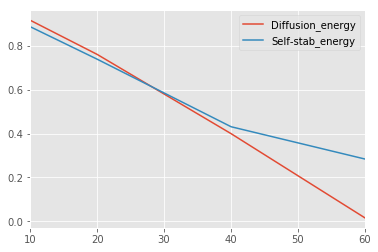

In [16]:
synth[["Diffusion_energy", "Self-stab_energy"]].plot()
plt.savefig('msthesis/images/scale_energy.png')

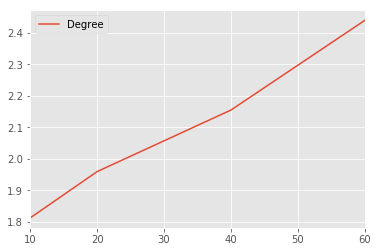

In [17]:
synth[["Degree"]].plot()
plt.savefig('msthesis/images/scale_degree.png')